In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import matplotlib 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import math
import numpy as np

# Map1D_E
---


In [2]:
from gpt.maps import Map1D_E
from gpt.lattice import Lattice

gun = Map1D_E('dcgun', 'fields/dcgun_GHV_1D.gdf')
?gun

Type:        Map1D_E
String form:
Name: dcgun
Type: Map1D_E
s-entrance: 0 m.
s-exit: 0.15 m.
Length: 0.15
Width: 0.2 m.
File:        ~/GitHub/lume-gpt/gpt/maps.py
Docstring:   Defines a 1D [z, Ez] cylindrically symmetric electric field map object

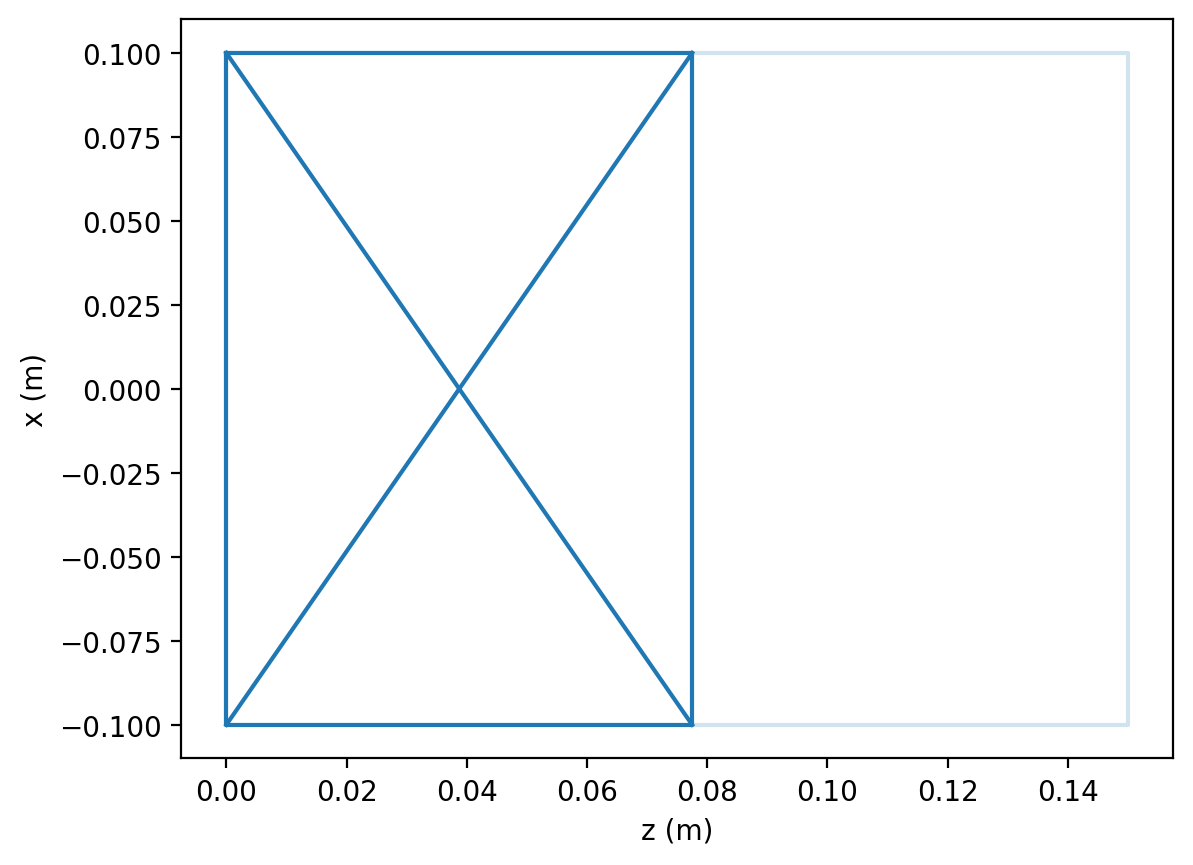

In [3]:
gun.plot_floor()

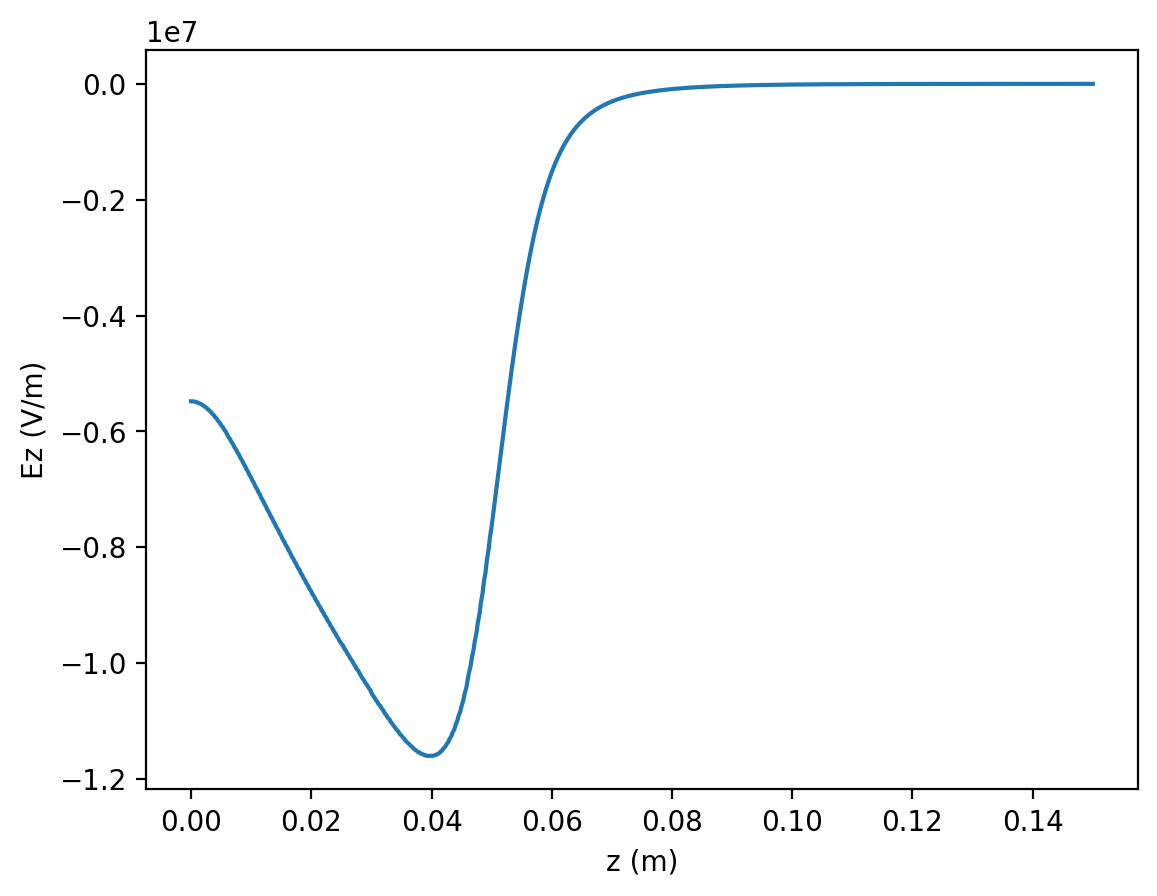

In [4]:
gun.plot_field_profile()

In [5]:
for line in gun.gpt_lines(): print(line)

dcgun_x = 0.0;
dcgun_y = 0.0;
dcgun_z = 0.0;
dcgun_scale = 1;
Map1D_E("wcs", dcgun_x, dcgun_y, dcgun_z, 1, 0, 0, 0, 1, 0, "/Users/colwyngulliford/GitHub/lume-gpt/examples/elements/fields/dcgun_GHV_1D.gdf", "z", "Ez", dcgun_scale);


In [6]:
gun.field_integral

-500043.32109424996